<a href="https://colab.research.google.com/github/NiceAsiv/Homework/blob/main/XJTU/AdvAI/DLG_minist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 在mnist数据集上验证效果

In [ ]:
import torch
print("PyTorch版本:", torch.__version__)
print("CUDA是否可用:", torch.cuda.is_available())
print("CUDA版本:", torch.version.cuda)
print("GPU名称:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

PyTorch版本: 2.5.1+cu121
CUDA是否可用: True
CUDA版本: 12.1
GPU名称: Tesla T4


Running on cuda


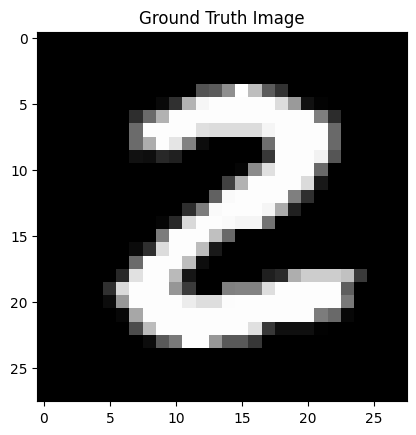

Ground Truth Label: 2


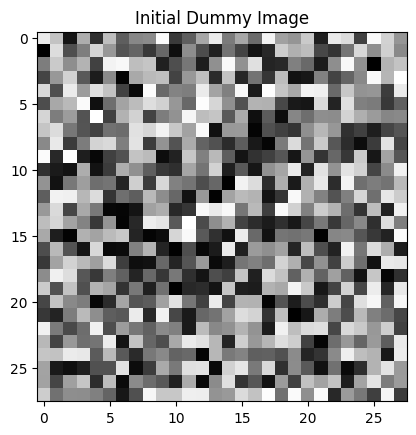

Iteration 0, Loss: 4.507389545440674
Iteration 10, Loss: 9.026766929309815e-05
Iteration 20, Loss: 1.1160909707541578e-05
Iteration 30, Loss: 1.1336301497522072e-07
Iteration 40, Loss: 8.205720547493911e-08
Iteration 50, Loss: 8.205706336639196e-08
Iteration 60, Loss: 8.205714863152025e-08
Iteration 70, Loss: 8.20567720438703e-08
Iteration 80, Loss: 8.205687862528066e-08
Iteration 90, Loss: 8.205725521293061e-08
Iteration 100, Loss: 8.205699231211838e-08
Iteration 110, Loss: 8.205677914929765e-08
Iteration 120, Loss: 8.205733337263155e-08
Iteration 130, Loss: 8.205719836951175e-08
Iteration 140, Loss: 8.205721968579383e-08
Iteration 150, Loss: 8.205697810126367e-08
Iteration 160, Loss: 8.205737600519569e-08
Iteration 170, Loss: 8.205727652921269e-08
Iteration 180, Loss: 8.205743995404191e-08
Iteration 190, Loss: 8.205673651673351e-08
Iteration 200, Loss: 8.205690704699009e-08
Iteration 210, Loss: 8.205739021605041e-08
Iteration 220, Loss: 8.205703494468253e-08
Iteration 230, Loss: 8.20

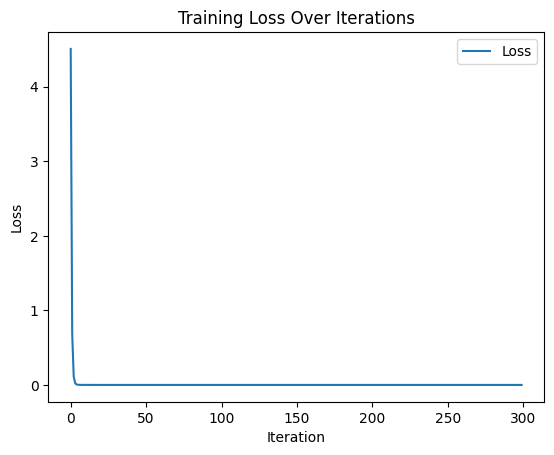

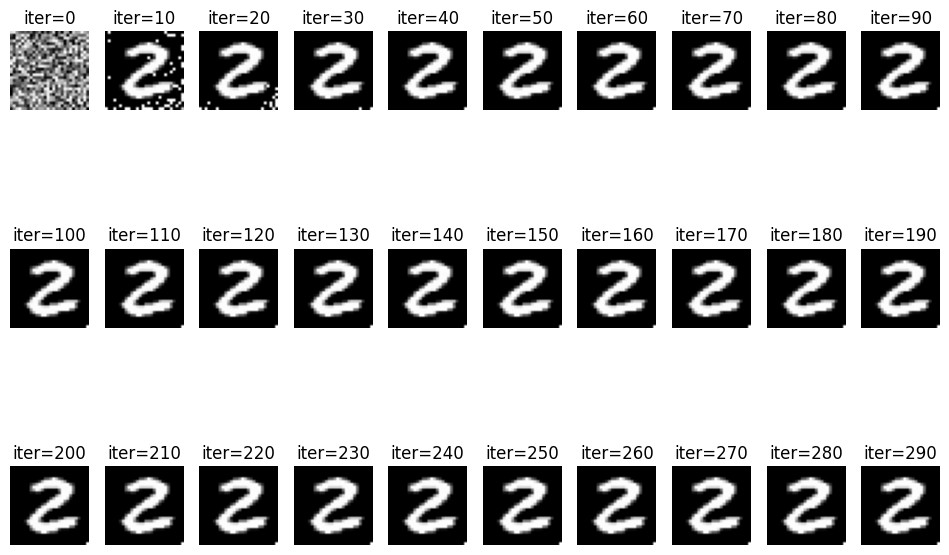

Dummy label is 2


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 加载数据集
dst = datasets.MNIST("~/data", download=True, transform=transforms.ToTensor())
tp = transforms.ToPILImage()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}")

# 标签转为 One-Hot 编码
def label_to_onehot(target, num_classes=10):  # 修改 num_classes 为 10（MNIST 的类别数）
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

# 自定义 One-Hot 交叉熵
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(-target * F.log_softmax(pred, dim=-1), dim=1))

# 初始化权重
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

# 修改模型定义
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=5, padding=5//2, stride=2),  # 修改输入通道数为 1
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(588, 10)  # 修改输出类别为 10（MNIST 的类别数）
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# 初始化模型
net = LeNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

# 选择一张图片及其标签
img_index = 25
gt_data = dst[img_index][0].to(device).unsqueeze(0)  # MNIST 数据是灰度图，单通道
gt_label = torch.tensor([dst[img_index][1]], device=device)
gt_onehot_label = label_to_onehot(gt_label, num_classes=10)

# 可视化 Ground Truth 图像
plt.imshow(tp(gt_data[0].cpu()), cmap="gray")
plt.title("Ground Truth Image")
plt.show()
print(f"Ground Truth Label: {gt_label.item()}")

# 计算真实梯度
y = criterion(net(gt_data), gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())
original_dy_dx = [_.detach().clone() for _ in dy_dx]

# 生成随机数据和标签
dummy_data = torch.randn(gt_data.size(), requires_grad=True, device=device)
dummy_label = torch.randn(gt_onehot_label.size(), requires_grad=True, device=device)

# 可视化伪造数据
plt.imshow(tp(dummy_data[0].cpu()), cmap="gray")
plt.title("Initial Dummy Image")
plt.show()

# 使用 LBFGS 优化器
optimizer = torch.optim.LBFGS([dummy_data, dummy_label])
history = []
loss_history = []

for iters in range(300):
    def closure():
        optimizer.zero_grad()
        pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()
        return grad_diff

    optimizer.step(closure)
    current_loss = closure().item()
    if iters % 10 == 0:
        print(f"Iteration {iters}, Loss: {current_loss}")
    history.append(tp(dummy_data[0].detach().cpu()))
    loss_history.append(current_loss)

# 绘制训练过程的 Loss 变化
plt.figure()
plt.plot(range(len(loss_history)), loss_history, label="Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Over Iterations")
plt.legend()
plt.show()

# 可视化恢复过程
plt.figure(figsize=(12, 8))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(history[i * 10], cmap="gray")
    plt.title(f"iter={i * 10}")
    plt.axis('off')
plt.show()

print(f"Dummy label is {torch.argmax(dummy_label, dim=-1).item()}")